In [1]:
!pip install kaggle

     |████████████████████████████████| 59 kB 9.1 MB/s  eta 0:00:01
     |████████████████████████████████| 78 kB 738 kB/s  eta 0:00:01
  Created wheel for kaggle: filename=kaggle-1.5.10-py3-none-any.whl size=73269 sha256=0db242022c50840e4218c022c1e0c0b518cadcac3c4ef061e4bf27c08de14ad7
  Stored in directory: /home/ec2-user/.cache/pip/wheels/1c/dd/dd/c493e6f981182c1411e288c553310f76e212bac3afbdac1294
  Created wheel for python-slugify: filename=python_slugify-4.0.1-py2.py3-none-any.whl size=6767 sha256=aa9c73266cfe4e0192bba24af63aafaed2b6fc68007bd32a956a015700e21a2c
  Stored in directory: /home/ec2-user/.cache/pip/wheels/72/e6/db/122611605e60148f54ee2abaca98b2bbeafc6e22486a867bad
Successfully built kaggle python-slugify
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [8]:
!kaggle competitions download -c titanic

/bin/sh: kaggle: command not found


In [11]:
!unzip titanic.zip

Archive:  titanic.zip
  inflating: gender_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
# https://www.kaggle.com/gunesevitan/titanic-advanced-feature-engineering-tutorial

In [12]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

import time
import string
import warnings
warnings.filterwarnings('ignore')

SEED = 42

In [13]:
import numpy as np

In [14]:
def concat_df(train_data, test_data):
    # Returns a concatenated df of training and test set
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

def divide_df(all_data):
    # Returns divided dfs of training and test set
    return all_data.loc[:890], all_data.loc[891:].drop(['Survived'], axis=1)

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_all = concat_df(df_train, df_test)

df_train.name = 'Training Set'
df_test.name = 'Test Set'
df_all.name = 'All Set' 

dfs = [df_train, df_test]

print('Number of Training Examples = {}'.format(df_train.shape[0]))
print('Number of Test Examples = {}\n'.format(df_test.shape[0]))
print('Training X Shape = {}'.format(df_train.shape))
#print('Training y Shape = {}\n'.format(df_train['Survived'].shape[0]))
print('Test X Shape = {}'.format(df_test.shape))
print('Test y Shape = {}\n'.format(df_test.shape[0]))
print(df_train.columns)
print(df_test.columns)

Number of Training Examples = 891
Number of Test Examples = 418

Training X Shape = (891, 12)
Test X Shape = (418, 11)
Test y Shape = 418

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [6]:
print(df_train.info())
df_train.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 890 entries, 0 to 889
Data columns (total 44 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   0.0                 890 non-null    float64
 1   2                   890 non-null    int64  
 2   0                   890 non-null    int64  
 3   1                   890 non-null    int64  
 4   0.1                 890 non-null    int64  
 5   0.3838383838383838  890 non-null    float64
 6   0.0.1               890 non-null    float64
 7   0.0.2               890 non-null    float64
 8   0.0.3               890 non-null    float64
 9   1.0                 890 non-null    float64
 10  0.0.4               890 non-null    float64
 11  1.0.1               890 non-null    float64
 12  0.0.5               890 non-null    float64
 13  0.0.6               890 non-null    float64
 14  0.0.7               890 non-null    float64
 15  0.0.8               890 non-null    float64
 16  0.0.9   

,0.0,2,0,1,0.1,0.3838383838383838,0.0.1,0.0.2,0.0.3,1.0,...,1.0.4,0.0.25,0.0.26,0.0.27,0.0.28,0.0.29,0.0.30,0.0.31,0.0.32,1.0.5
160,1.0,7,7,2,1,0.691919,0.5,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
407,0.0,1,2,1,0,0.383838,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
467,0.0,3,1,1,0,0.383838,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [5]:
print(df_test.info())
df_test.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
None


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
103,995,3,"Johansson Palmquist, Mr. Oskar Leander",male,26.0,0,0,347070,7.7750,NaN,S
221,1113,3,"Reynolds, Mr. Harold J",male,21.0,0,0,342684,8.0500,NaN,S
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q


In [15]:
def display_missing(df):    
    for col in df.columns.tolist():          
        print('{} column missing values: {}'.format(col, df[col].isnull().sum()))
    print('\n')
    
for df in dfs:
    print('{}'.format(df.name))
    display_missing(df)

Training Set
PassengerId column missing values: 0
Survived column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 177
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 0
Cabin column missing values: 687
Embarked column missing values: 2


Test Set
PassengerId column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 86
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 1
Cabin column missing values: 327
Embarked column missing values: 0




In [16]:
df_all_corr = df_all.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_all_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_all_corr[df_all_corr['Feature 1'] == 'Age']

,Feature 1,Feature 2,Correlation Coefficient
6,Age,Age,1.000000
9,Age,Pclass,0.408106
17,Age,SibSp,0.243699
22,Age,Fare,0.178740
25,Age,Parch,0.150917
29,Age,Survived,0.077221
41,Age,PassengerId,0.028814


In [17]:
age_by_pclass_sex = df_all.groupby(['Sex', 'Pclass']).median()['Age']

for pclass in range(1, 4):
    for sex in ['female', 'male']:
        print('Median age of Pclass {} {}s: {}'.format(pclass, sex, age_by_pclass_sex[sex][pclass]))
print('Median age of all passengers: {}'.format(df_all['Age'].median()))

# Filling the missing values in Age with the medians of Sex and Pclass groups
df_all['Age'] = df_all.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

Median age of Pclass 1 females: 36.0
Median age of Pclass 1 males: 42.0
Median age of Pclass 2 females: 28.0
Median age of Pclass 2 males: 29.5
Median age of Pclass 3 females: 22.0
Median age of Pclass 3 males: 25.0
Median age of all passengers: 28.0


In [18]:
# Filling the missing values in Embarked with S
df_all['Embarked'] = df_all['Embarked'].fillna('S')

In [19]:
med_fare = df_all.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
# Filling the missing value in Fare with the median Fare of 3rd class alone passenger
df_all['Fare'] = df_all['Fare'].fillna(med_fare)

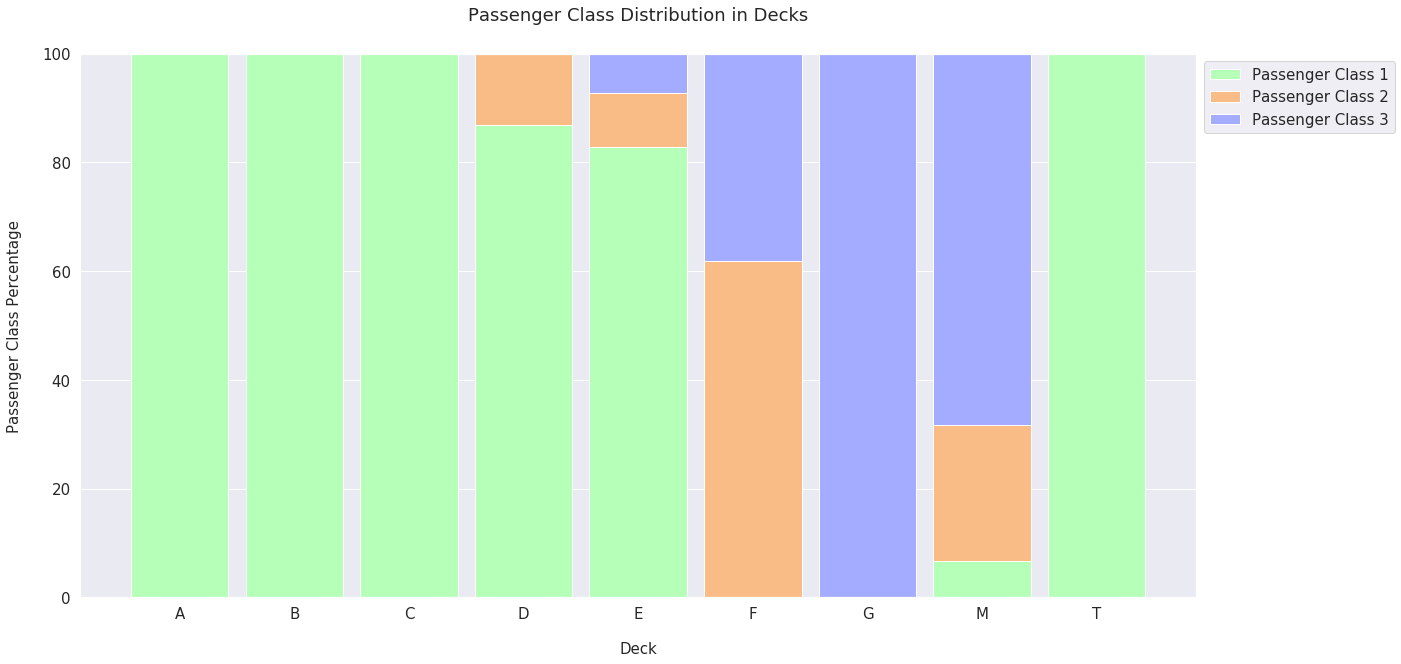

In [20]:
# Creating Deck column from the first letter of the Cabin column (M stands for Missing)
df_all['Deck'] = df_all['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')

df_all_decks = df_all.groupby(['Deck', 'Pclass']).count().drop(columns=['Survived', 'Sex', 'Age', 'SibSp', 'Parch', 
                                                                        'Fare', 'Embarked', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name': 'Count'}).transpose()

def get_pclass_dist(df):
    
    # Creating a dictionary for every passenger class count in every deck
    deck_counts = {'A': {}, 'B': {}, 'C': {}, 'D': {}, 'E': {}, 'F': {}, 'G': {}, 'M': {}, 'T': {}}
    decks = df.columns.levels[0]    
    
    for deck in decks:
        for pclass in range(1, 4):
            try:
                count = df[deck][pclass][0]
                deck_counts[deck][pclass] = count 
            except KeyError:
                deck_counts[deck][pclass] = 0
                
    df_decks = pd.DataFrame(deck_counts)    
    deck_percentages = {}

    # Creating a dictionary for every passenger class percentage in every deck
    for col in df_decks.columns:
        deck_percentages[col] = [(count / df_decks[col].sum()) * 100 for count in df_decks[col]]
        
    return deck_counts, deck_percentages

def display_pclass_dist(percentages):
    
    df_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M', 'T')
    bar_count = np.arange(len(deck_names))  
    bar_width = 0.85
    
    pclass1 = df_percentages[0]
    pclass2 = df_percentages[1]
    pclass3 = df_percentages[2]
    
    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, pclass1, color='#b5ffb9', edgecolor='white', width=bar_width, label='Passenger Class 1')
    plt.bar(bar_count, pclass2, bottom=pclass1, color='#f9bc86', edgecolor='white', width=bar_width, label='Passenger Class 2')
    plt.bar(bar_count, pclass3, bottom=pclass1 + pclass2, color='#a3acff', edgecolor='white', width=bar_width, label='Passenger Class 3')

    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Passenger Class Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Passenger Class Distribution in Decks', size=18, y=1.05)   
    
    plt.show()    

all_deck_count, all_deck_per = get_pclass_dist(df_all_decks)
display_pclass_dist(all_deck_per)

In [21]:
# Passenger in the T deck is changed to A
idx = df_all[df_all['Deck'] == 'T'].index
df_all.loc[idx, 'Deck'] = 'A'

In [22]:
# Dropping the Cabin feature
df_all.drop(['Cabin'], inplace=True, axis=1)

df_train, df_test = divide_df(df_all)
dfs = [df_train, df_test]

for df in dfs:
    display_missing(df)

Age column missing values: 0
Embarked column missing values: 0
Fare column missing values: 0
Name column missing values: 0
Parch column missing values: 0
PassengerId column missing values: 0
Pclass column missing values: 0
Sex column missing values: 0
SibSp column missing values: 0
Survived column missing values: 0
Ticket column missing values: 0
Deck column missing values: 0


Age column missing values: 0
Embarked column missing values: 0
Fare column missing values: 0
Name column missing values: 0
Parch column missing values: 0
PassengerId column missing values: 0
Pclass column missing values: 0
Sex column missing values: 0
SibSp column missing values: 0
Ticket column missing values: 0
Deck column missing values: 0




342 of 891 passengers survived and it is the 38.38% of the training set.
549 of 891 passengers didnt survive and it is the 61.62% of the training set.


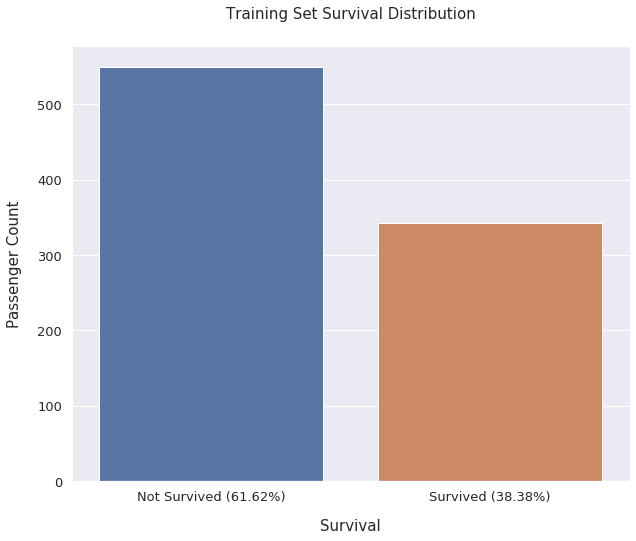

In [23]:
survived = df_train['Survived'].value_counts()[1]
not_survived = df_train['Survived'].value_counts()[0]
survived_per = survived / df_train.shape[0] * 100
not_survived_per = not_survived / df_train.shape[0] * 100

print('{} of {} passengers survived and it is the {:.2f}% of the training set.'.format(survived, df_train.shape[0], survived_per))
print('{} of {} passengers didnt survive and it is the {:.2f}% of the training set.'.format(not_survived, df_train.shape[0], not_survived_per))

plt.figure(figsize=(10, 8))
sns.countplot(df_train['Survived'])

plt.xlabel('Survival', size=15, labelpad=15)
plt.ylabel('Passenger Count', size=15, labelpad=15)
plt.xticks((0, 1), ['Not Survived ({0:.2f}%)'.format(not_survived_per), 'Survived ({0:.2f}%)'.format(survived_per)])
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)

plt.title('Training Set Survival Distribution', size=15, y=1.05)

plt.show()


In [24]:
df_train_corr = df_train.drop(['PassengerId'], axis=1).corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_train_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_train_corr.drop(df_train_corr.iloc[1::2].index, inplace=True)
df_train_corr_nd = df_train_corr.drop(df_train_corr[df_train_corr['Correlation Coefficient'] == 1.0].index)

df_test_corr = df_test.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_test_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_test_corr.drop(df_test_corr.iloc[1::2].index, inplace=True)
df_test_corr_nd = df_test_corr.drop(df_test_corr[df_test_corr['Correlation Coefficient'] == 1.0].index)

In [25]:
# Training set high correlations
corr = df_train_corr_nd['Correlation Coefficient'] > 0.1
df_train_corr_nd[corr]

,Feature 1,Feature 2,Correlation Coefficient
6,Pclass,Fare,0.549500
8,Pclass,Age,0.417667
10,SibSp,Parch,0.414838
12,Survived,Pclass,0.338481
14,Survived,Fare,0.257307
16,SibSp,Age,0.249747
18,Parch,Fare,0.216225
20,Age,Parch,0.176733
22,SibSp,Fare,0.159651
24,Age,Fare,0.124061


In [17]:
# Test set high correlations
corr = df_test_corr_nd['Correlation Coefficient'] > 0.1
df_test_corr_nd[corr]

,Feature 1,Feature 2,Correlation Coefficient
6,Fare,Pclass,0.577489
8,Age,Pclass,0.526789
10,Age,Fare,0.345347
12,SibSp,Parch,0.306895
14,Fare,Parch,0.230410
16,SibSp,Fare,0.172032


In [26]:
df_all = concat_df(df_train, df_test)
df_all.head()

,Age,Deck,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,M,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,M,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,M,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


In [19]:
# FE

In [27]:
df_all['Fare'] = pd.qcut(df_all['Fare'], 13)

In [28]:
df_all['Age'] = pd.qcut(df_all['Age'], 10)


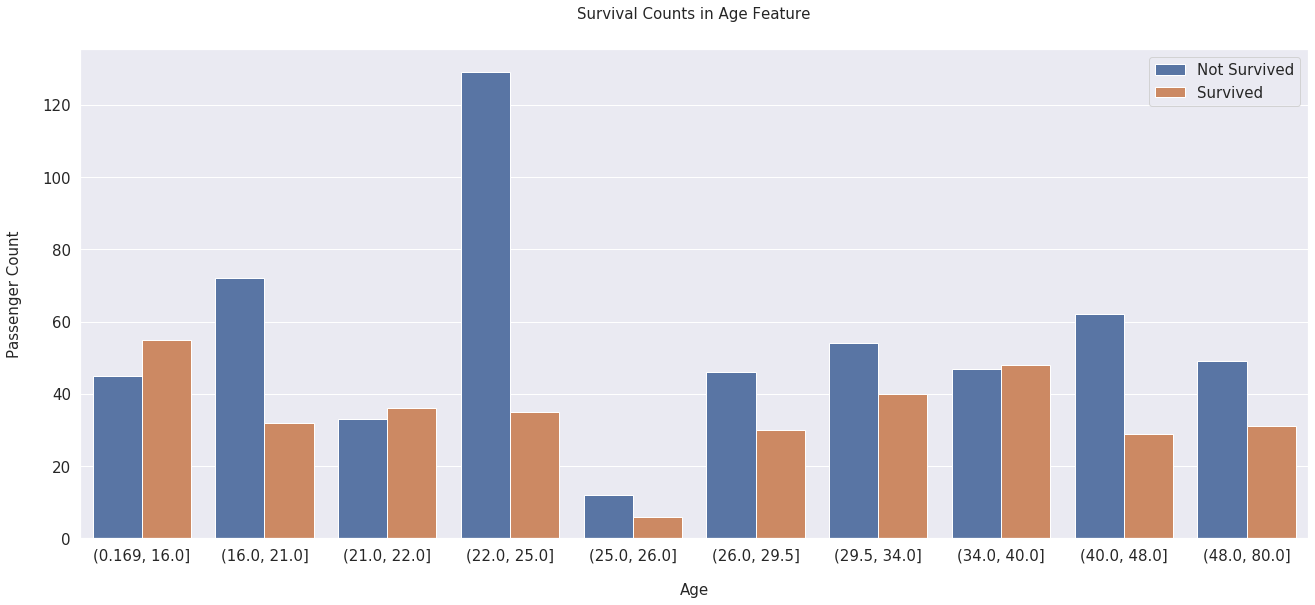

In [22]:
fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Age', hue='Survived', data=df_all)

plt.xlabel('Age', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Survival Counts in {} Feature'.format('Age'), size=15, y=1.05)

plt.show()

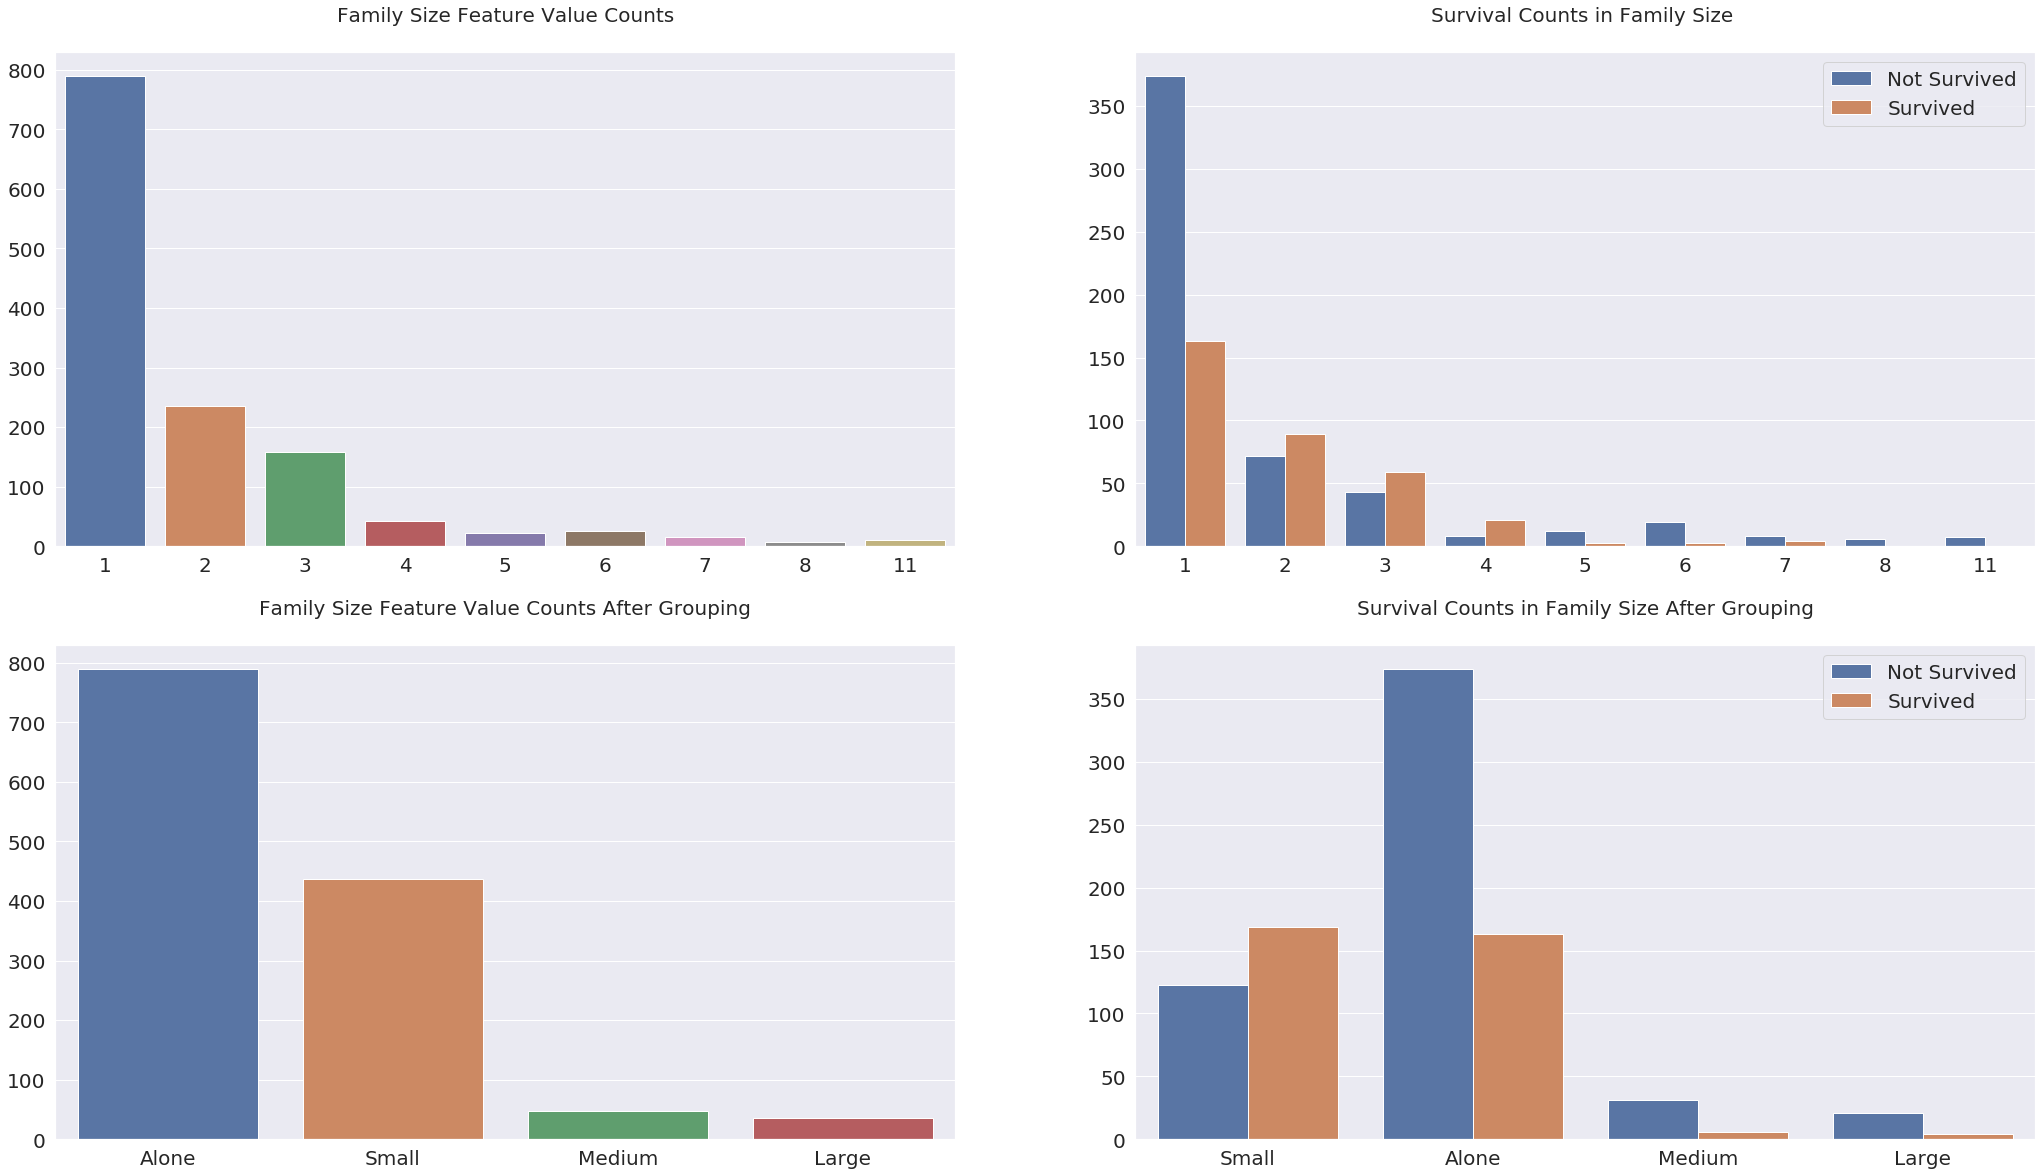

In [29]:
df_all['Family_Size'] = df_all['SibSp'] + df_all['Parch'] + 1

fig, axs = plt.subplots(figsize=(20, 20), ncols=2, nrows=2)
plt.subplots_adjust(right=1.5)

sns.barplot(x=df_all['Family_Size'].value_counts().index, y=df_all['Family_Size'].value_counts().values, ax=axs[0][0])
sns.countplot(x='Family_Size', hue='Survived', data=df_all, ax=axs[0][1])

axs[0][0].set_title('Family Size Feature Value Counts', size=20, y=1.05)
axs[0][1].set_title('Survival Counts in Family Size ', size=20, y=1.05)

family_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}
df_all['Family_Size_Grouped'] = df_all['Family_Size'].map(family_map)

sns.barplot(x=df_all['Family_Size_Grouped'].value_counts().index, y=df_all['Family_Size_Grouped'].value_counts().values, ax=axs[1][0])
sns.countplot(x='Family_Size_Grouped', hue='Survived', data=df_all, ax=axs[1][1])

axs[1][0].set_title('Family Size Feature Value Counts After Grouping', size=20, y=1.05)
axs[1][1].set_title('Survival Counts in Family Size After Grouping', size=20, y=1.05)

for i in range(2):
    axs[i][1].legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 20})
    for j in range(2):
        axs[i][j].tick_params(axis='x', labelsize=20)
        axs[i][j].tick_params(axis='y', labelsize=20)
        axs[i][j].set_xlabel('')
        axs[i][j].set_ylabel('')

plt.show()

In [30]:
df_all['Ticket_Frequency'] = df_all.groupby('Ticket')['Ticket'].transform('count')


In [31]:
df_all['Title'] = df_all['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
df_all['Is_Married'] = 0
df_all['Is_Married'].loc[df_all['Title'] == 'Mrs'] = 1

In [32]:
def extract_surname(data):    
    
    families = []
    
    for i in range(len(data)):        
        name = data.iloc[i]

        if '(' in name:
            name_no_bracket = name.split('(')[0] 
        else:
            name_no_bracket = name
            
        family = name_no_bracket.split(',')[0]
        title = name_no_bracket.split(',')[1].strip().split(' ')[0]
        
        for c in string.punctuation:
            family = family.replace(c, '').strip()
            
        families.append(family)
            
    return families

df_all['Family'] = extract_surname(df_all['Name'])
df_train = df_all.loc[:890]
df_test = df_all.loc[891:]
dfs = [df_train, df_test]

In [33]:
# Creating a list of families and tickets that are occuring in both training and test set
non_unique_families = [x for x in df_train['Family'].unique() if x in df_test['Family'].unique()]
non_unique_tickets = [x for x in df_train['Ticket'].unique() if x in df_test['Ticket'].unique()]

df_family_survival_rate = df_train.groupby('Family')['Survived', 'Family','Family_Size'].median()
df_ticket_survival_rate = df_train.groupby('Ticket')['Survived', 'Ticket','Ticket_Frequency'].median()

family_rates = {}
ticket_rates = {}

for i in range(len(df_family_survival_rate)):
    # Checking a family exists in both training and test set, and has members more than 1
    if df_family_survival_rate.index[i] in non_unique_families and df_family_survival_rate.iloc[i, 1] > 1:
        family_rates[df_family_survival_rate.index[i]] = df_family_survival_rate.iloc[i, 0]

for i in range(len(df_ticket_survival_rate)):
    # Checking a ticket exists in both training and test set, and has members more than 1
    if df_ticket_survival_rate.index[i] in non_unique_tickets and df_ticket_survival_rate.iloc[i, 1] > 1:
        ticket_rates[df_ticket_survival_rate.index[i]] = df_ticket_survival_rate.iloc[i, 0]

In [34]:
mean_survival_rate = np.mean(df_train['Survived'])

train_family_survival_rate = []
train_family_survival_rate_NA = []
test_family_survival_rate = []
test_family_survival_rate_NA = []

for i in range(len(df_train)):
    if df_train['Family'][i] in family_rates:
        train_family_survival_rate.append(family_rates[df_train['Family'][i]])
        train_family_survival_rate_NA.append(1)
    else:
        train_family_survival_rate.append(mean_survival_rate)
        train_family_survival_rate_NA.append(0)
        
for i in range(len(df_test)):
    if df_test['Family'].iloc[i] in family_rates:
        test_family_survival_rate.append(family_rates[df_test['Family'].iloc[i]])
        test_family_survival_rate_NA.append(1)
    else:
        test_family_survival_rate.append(mean_survival_rate)
        test_family_survival_rate_NA.append(0)
        
df_train['Family_Survival_Rate'] = train_family_survival_rate
df_train['Family_Survival_Rate_NA'] = train_family_survival_rate_NA
df_test['Family_Survival_Rate'] = test_family_survival_rate
df_test['Family_Survival_Rate_NA'] = test_family_survival_rate_NA

train_ticket_survival_rate = []
train_ticket_survival_rate_NA = []
test_ticket_survival_rate = []
test_ticket_survival_rate_NA = []

for i in range(len(df_train)):
    if df_train['Ticket'][i] in ticket_rates:
        train_ticket_survival_rate.append(ticket_rates[df_train['Ticket'][i]])
        train_ticket_survival_rate_NA.append(1)
    else:
        train_ticket_survival_rate.append(mean_survival_rate)
        train_ticket_survival_rate_NA.append(0)
        
for i in range(len(df_test)):
    if df_test['Ticket'].iloc[i] in ticket_rates:
        test_ticket_survival_rate.append(ticket_rates[df_test['Ticket'].iloc[i]])
        test_ticket_survival_rate_NA.append(1)
    else:
        test_ticket_survival_rate.append(mean_survival_rate)
        test_ticket_survival_rate_NA.append(0)
        
df_train['Ticket_Survival_Rate'] = train_ticket_survival_rate
df_train['Ticket_Survival_Rate_NA'] = train_ticket_survival_rate_NA
df_test['Ticket_Survival_Rate'] = test_ticket_survival_rate
df_test['Ticket_Survival_Rate_NA'] = test_ticket_survival_rate_NA

In [35]:
for df in [df_train, df_test]:
    df['Survival_Rate'] = (df['Ticket_Survival_Rate'] + df['Family_Survival_Rate']) / 2
    df['Survival_Rate_NA'] = (df['Ticket_Survival_Rate_NA'] + df['Family_Survival_Rate_NA']) / 2   

In [36]:
non_numeric_features = ['Embarked', 'Sex', 'Deck', 'Title', 'Family_Size_Grouped', 'Age', 'Fare']

for df in dfs:
    for feature in non_numeric_features:        
        df[feature] = LabelEncoder().fit_transform(df[feature])

In [37]:
cat_features = ['Pclass', 'Sex', 'Deck', 'Embarked', 'Title', 'Family_Size_Grouped']
encoded_features = []

for df in dfs:
    for feature in cat_features:
        encoded_feat = OneHotEncoder().fit_transform(df[feature].values.reshape(-1, 1)).toarray()
        n = df[feature].nunique()
        cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
        encoded_df = pd.DataFrame(encoded_feat, columns=cols)
        encoded_df.index = df.index
        encoded_features.append(encoded_df)

df_train = pd.concat([df_train, *encoded_features[:6]], axis=1)
df_test = pd.concat([df_test, *encoded_features[6:]], axis=1)

In [38]:
df_all = concat_df(df_train, df_test)
drop_cols = ['Deck', 'Embarked', 'Family', 'Family_Size', 'Family_Size_Grouped', #'Survived',
             'Name', 'Parch', 'PassengerId', 'Pclass', 'Sex', 'SibSp', 'Ticket', 'Title',
            'Ticket_Survival_Rate', 'Family_Survival_Rate', 'Ticket_Survival_Rate_NA', 'Family_Survival_Rate_NA']

df_all.drop(columns=drop_cols, inplace=True)

df_all.head()

,Age,Deck_1,Deck_2,Deck_3,Deck_4,Deck_5,Deck_6,Deck_7,Deck_8,Embarked_1,...,Title_16,Title_17,Title_2,Title_3,Title_4,Title_5,Title_6,Title_7,Title_8,Title_9
0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,7,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
X_train = StandardScaler().fit_transform(df_train.drop(columns=drop_cols))
y_train = df_train['Survived'].values
X_test = StandardScaler().fit_transform(df_test.drop(columns=drop_cols))

print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_test shape: {}'.format(X_test.shape))

X_train shape: (891, 44)
y_train shape: (891,)
X_test shape: (418, 36)


In [41]:
# Autopilot and some models require that the test data have the same columns as the training data, so lets fix it
X_train_df = pd.DataFrame(X_train, columns=df_train.columns.drop(drop_cols))
X_test_df = pd.DataFrame(X_test, columns=df_test.columns.drop(drop_cols))
missing_cols = list(set(X_train_df.columns) - set(X_test_df.columns))
for col in missing_cols:
    X_test_df[col] = 0
X_train_df.shape, X_test_df.shape
# Should be the same number of columns

((891, 44), (418, 44))

In [41]:
### END OF FEATURE ENGINEERING NOW WE ARE GOING TO TRY DIFFERENT APPROACHES TO 
# Following the Kaggle Kernel, this is where he start to train models, he uses Random Forest.

In [42]:
# import libraries
import boto3, re, sys, math, json, os, sagemaker, urllib.request
from sagemaker import get_execution_role
import numpy as np                                
import pandas as pd                               
import matplotlib.pyplot as plt                   
from IPython.display import Image                 
from IPython.display import display               
from time import gmtime, strftime                 
from sagemaker.predictor import csv_serializer   

region = boto3.Session().region_name

session = sagemaker.Session()
# Define IAM role and assign S3 bucket
role = get_execution_role()
# You can modify the following to use a bucket of your choosing
bucket = session.default_bucket()
prefix = 'sagemaker/titanic'
sm = boto3.Session().client(service_name='sagemaker',region_name=region)

### START: AUTOPILOT FOR THIS FIRST SUBMISSION

In [43]:
# https://github.com/aws/amazon-sagemaker-examples/blob/master/autopilot/autopilot_customer_churn.ipynb
train_file = 'train.csv';
X_train_df.to_csv(train_file, index=False, header=True)
train_data_s3_path = session.upload_data(path=train_file, key_prefix=prefix + "/train")
print('Train data uploaded to: ' + train_data_s3_path)

test_file = 'test.csv';
X_test_df.to_csv(test_file, index=False, header=False)
test_data_s3_path = session.upload_data(path=test_file, key_prefix=prefix + "/test")
print('Test data uploaded to: ' + test_data_s3_path)

Train data uploaded to: s3://sagemaker-us-east-1-475414269301/sagemaker/titanic/train/train.csv
Test data uploaded to: s3://sagemaker-us-east-1-475414269301/sagemaker/titanic/test/test.csv


In [44]:
# Autopilot config
input_data_config = [{
      'DataSource': {
        'S3DataSource': {
          'S3DataType': 'S3Prefix',
          'S3Uri': 's3://{}/{}/train'.format(bucket,prefix)
        }
      },
      'TargetAttributeName': 'Survived'
    }
  ]

output_data_config = {
    'S3OutputPath': 's3://{}/{}/output'.format(bucket,prefix)
  }

In [45]:
from time import gmtime, strftime, sleep
timestamp_suffix = strftime('%d-%H-%M-%S', gmtime())

auto_ml_job_name = 'automl-churn-' + timestamp_suffix
print('AutoMLJobName: ' + auto_ml_job_name)

sm.create_auto_ml_job(AutoMLJobName=auto_ml_job_name,
                      InputDataConfig=input_data_config,
                      OutputDataConfig=output_data_config,
                      AutoMLJobConfig={'CompletionCriteria':
                                       {'MaxCandidates': 50}
                                      },
                      RoleArn=role)

AutoMLJobName: automl-churn-03-15-42-12


{'AutoMLJobArn': 'arn:aws:sagemaker:us-east-1:475414269301:automl-job/automl-churn-03-15-42-12',
 'ResponseMetadata': {'RequestId': '24b732ad-6403-4268-8ba3-08412ff7538f',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '24b732ad-6403-4268-8ba3-08412ff7538f',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '95',
   'date': 'Wed, 03 Mar 2021 15:42:14 GMT'},
  'RetryAttempts': 0}}

In [46]:
#Store the AutoMLJobName name for use in subsequent notebooks 
%store auto_ml_job_name
auto_ml_job_name

Stored 'auto_ml_job_name' (str)


'automl-churn-03-15-42-12'

In [ ]:
print ('JobStatus - Secondary Status')
print('------------------------------')


describe_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
print (describe_response['AutoMLJobStatus'] + " - " + describe_response['AutoMLJobSecondaryStatus'])
job_run_status = describe_response['AutoMLJobStatus']
    
while job_run_status not in ('Failed', 'Completed', 'Stopped'):
    describe_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
    job_run_status = describe_response['AutoMLJobStatus']
    
    print (describe_response['AutoMLJobStatus'] + " - " + describe_response['AutoMLJobSecondaryStatus'])
    sleep(30)

JobStatus - Secondary Status
------------------------------
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - Fea

In [48]:
print(describe_response['AutoMLJobArtifacts']['CandidateDefinitionNotebookLocation'])
print(describe_response['AutoMLJobArtifacts']['DataExplorationNotebookLocation'])

candidate_nbk = describe_response['AutoMLJobArtifacts']['CandidateDefinitionNotebookLocation']
data_explore_nbk = describe_response['AutoMLJobArtifacts']['DataExplorationNotebookLocation']

s3://sagemaker-us-east-1-475414269301/sagemaker/titanic/output/automl-churn-03-15-42-12/sagemaker-automl-candidates/pr-1-c4cf1a7550d04a7ba4a1e624712982dc421136ae7c4345a1a981f305f9/notebooks/SageMakerAutopilotCandidateDefinitionNotebook.ipynb
s3://sagemaker-us-east-1-475414269301/sagemaker/titanic/output/automl-churn-03-15-42-12/sagemaker-automl-candidates/pr-1-c4cf1a7550d04a7ba4a1e624712982dc421136ae7c4345a1a981f305f9/notebooks/SageMakerAutopilotDataExplorationNotebook.ipynb


In [49]:
def split_s3_path(s3_path):
    path_parts=s3_path.replace("s3://","").split("/")
    bucket=path_parts.pop(0)
    key="/".join(path_parts)
    return bucket, key

s3_bucket, candidate_nbk_key = split_s3_path(candidate_nbk)
_, data_explore_nbk_key = split_s3_path(data_explore_nbk)

print(s3_bucket, candidate_nbk_key, data_explore_nbk_key)

session.download_data(path='./', bucket=s3_bucket, 
                                 key_prefix = candidate_nbk_key)

session.download_data(path='./', bucket=s3_bucket, 
                                 key_prefix = data_explore_nbk_key)

sagemaker-us-east-1-475414269301 sagemaker/titanic/output/automl-churn-03-15-42-12/sagemaker-automl-candidates/pr-1-c4cf1a7550d04a7ba4a1e624712982dc421136ae7c4345a1a981f305f9/notebooks/SageMakerAutopilotCandidateDefinitionNotebook.ipynb sagemaker/titanic/output/automl-churn-03-15-42-12/sagemaker-automl-candidates/pr-1-c4cf1a7550d04a7ba4a1e624712982dc421136ae7c4345a1a981f305f9/notebooks/SageMakerAutopilotDataExplorationNotebook.ipynb


In [50]:
best_candidate = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)['BestCandidate']
best_candidate_name = best_candidate['CandidateName']
print(best_candidate)
print('\n')
print("CandidateName: " + best_candidate_name)
print("FinalAutoMLJobObjectiveMetricName: " + best_candidate['FinalAutoMLJobObjectiveMetric']['MetricName'])
print("FinalAutoMLJobObjectiveMetricValue: " + str(best_candidate['FinalAutoMLJobObjectiveMetric']['Value']))

{'CandidateName': 'tuning-job-1-940d60d2fd89419582-015-da02af5f', 'FinalAutoMLJobObjectiveMetric': {'MetricName': 'validation:f1', 'Value': 0.8619899749755859}, 'ObjectiveStatus': 'Succeeded', 'CandidateSteps': [{'CandidateStepType': 'AWS::SageMaker::ProcessingJob', 'CandidateStepArn': 'arn:aws:sagemaker:us-east-1:475414269301:processing-job/db-1-7de1808b908a4a608ddb42952bd12db756b80dc8e41049b284c8cbb3df', 'CandidateStepName': 'db-1-7de1808b908a4a608ddb42952bd12db756b80dc8e41049b284c8cbb3df'}, {'CandidateStepType': 'AWS::SageMaker::TrainingJob', 'CandidateStepArn': 'arn:aws:sagemaker:us-east-1:475414269301:training-job/automl-chu-dpp1-1-3f9d1f4bbbf841d987940a9316825fc8a593ec05cc6d4', 'CandidateStepName': 'automl-chu-dpp1-1-3f9d1f4bbbf841d987940a9316825fc8a593ec05cc6d4'}, {'CandidateStepType': 'AWS::SageMaker::TransformJob', 'CandidateStepArn': 'arn:aws:sagemaker:us-east-1:475414269301:transform-job/automl-chu-dpp1-csv-1-5d5060b3687b473d8f098fbabcffa54777cfbd25d', 'CandidateStepName': '

In [51]:
#sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
#sm.list_auto_ml_jobs()
sm_dict =sm.list_candidates_for_auto_ml_job(AutoMLJobName=auto_ml_job_name)

In [52]:
for item in sm_dict['Candidates']:
    print(item['CandidateName'], item['FinalAutoMLJobObjectiveMetric'])
    print(item['InferenceContainers'][1]['Image'], "\n")

tuning-job-1-940d60d2fd89419582-050-bdb0cf35 {'MetricName': 'validation:f1', 'Value': 0.8129900097846985}
683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.0-1-cpu-py3 

tuning-job-1-940d60d2fd89419582-049-80271995 {'MetricName': 'validation:f1', 'Value': 0.810920000076294}
683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.0-1-cpu-py3 

tuning-job-1-940d60d2fd89419582-048-63c0c752 {'MetricName': 'validation:f1', 'Value': 0.7913299798965454}
683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.0-1-cpu-py3 

tuning-job-1-940d60d2fd89419582-043-fb19c498 {'MetricName': 'validation:f1', 'Value': 0.832539975643158}
683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.0-1-cpu-py3 

tuning-job-1-940d60d2fd89419582-047-bf70f2f4 {'MetricName': 'validation:f1', 'Value': 0.8119900226593018}
683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.0-1-cpu-py3 

tuning-job-1-940d60d2fd89419582-046-e0de4c58 {'MetricName': 'validation:f1', 

In [53]:
model_name = best_candidate_name + timestamp_suffix + "-model"
model_arn = sm.create_model(Containers=best_candidate['InferenceContainers'],
                            ModelName=model_name,
                            ExecutionRoleArn=role)

epc_name = best_candidate_name + timestamp_suffix + "-epc"
ep_config = sm.create_endpoint_config(EndpointConfigName = epc_name,
                                      ProductionVariants=[{'InstanceType': 'ml.m5.xlarge',
                                                           'InitialInstanceCount': 1,
                                                           'ModelName': model_name,
                                                           'VariantName': 'main'}])

ep_name = best_candidate_name + timestamp_suffix + "-ep"
create_endpoint_response = sm.create_endpoint(EndpointName=ep_name,
                                              EndpointConfigName=epc_name)


In [54]:
sm.get_waiter('endpoint_in_service').wait(EndpointName=ep_name)

In [61]:
from io import StringIO

if (sagemaker.__version__ < '2'):
    from sagemaker.predictor import RealTimePredictor
    from sagemaker.content_types import CONTENT_TYPE_CSV
    predictor = RealTimePredictor(
        endpoint=ep_name,
        sagemaker_session=session,
        content_type=CONTENT_TYPE_CSV,
        accept=CONTENT_TYPE_CSV)

    # Remove the target column from the test data
    test_data_inference = X_train_df.drop('Survived', axis=1)

    # Obtain predictions from SageMaker endpoint
    prediction = predictor.predict(test_data_inference.to_csv(sep=',', header=False, index=False)).decode('utf-8')

    # Load prediction in pandas and compare to ground truth
    prediction_df = pd.read_csv(StringIO(prediction), header=None)
    accuracy = (X_train_df.reset_index()['Survived'] == prediction_df[0]).sum() / len(test_data_inference)
    print('Accuracy: {}'.format(accuracy))

else:
    from sagemaker.predictor import Predictor
    from sagemaker.serializers import CSVSerializer
    from sagemaker.deserializers import CSVDeserializer
    predictor = Predictor(
        endpoint_name=ep_name,
        sagemaker_session=session,
        serializer=CSVSerializer(),
        deserializer=CSVDeserializer())
    
    # Remove the target column from the test data
    test_data_inference = X_train_df.drop('Survived', axis=1)
    #print(test_data_inference.head())

    # Obtain predictions from SageMaker endpoint
    prediction = predictor.predict(test_data_inference.to_csv(sep=',', header=False, index=False))
    
    # Load prediction in pandas and compare to ground truth
    prediction_df = pd.DataFrame(prediction)
    y_train_df = pd.DataFrame(y_train)
    prediction_df[0] = prediction_df[0].astype(float).apply(lambda x: 1.0 if x > 0.6 else 0.0)
    accuracy = (y_train_df[0] == prediction_df[0]).sum() / len(test_data_inference)
    print('Accuracy: {}'.format(accuracy))

Accuracy: 0.9102132435465768


In [62]:
# Predict on the test data
test_data_inference = X_test_df.drop('Survived', axis=1)
prediction = predictor.predict(test_data_inference.to_csv(sep=',', header=False, index=False))
prediction_df = pd.DataFrame(prediction)
prediction_df[0] = prediction_df[0].astype(float)

In [63]:
y_pred = prediction_df[0].astype(int)

submission_df = pd.DataFrame(columns=['PassengerId', 'Survived'])
submission_df['PassengerId'] = df_test['PassengerId']
submission_df['Survived'] = y_pred.values
submission_df.to_csv('submissions.csv', header=True, index=False)
submission_df.head(10)

,PassengerId,Survived
891,892,0
892,893,1
893,894,0
894,895,0
895,896,1
896,897,0
897,898,0
898,899,0
899,900,1
900,901,0


In [68]:
!kaggle competitions submit -c titanic -f submissions.csv -m "Submission using autopilot model with 50 candidates only"

100%|██████████████████████████████████████| 2.77k/2.77k [00:00<00:00, 6.10kB/s]
Successfully submitted to Titanic - Machine Learning from Disaster

In [69]:
# Deleting the hosted model and deleting the model (Frugality)
sm.delete_endpoint(EndpointName=ep_name) 
sm.delete_endpoint_config(EndpointConfigName=epc_name) 
sm.delete_model(ModelName=model_name)

{'ResponseMetadata': {'RequestId': 'fb6a98a0-a1a0-48a8-98dd-55a100ce6395',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'fb6a98a0-a1a0-48a8-98dd-55a100ce6395',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Wed, 03 Mar 2021 16:46:11 GMT'},
  'RetryAttempts': 0}}

### END Autopilot submission

In [70]:
#X_train = StandardScaler().fit_transform(df_train.drop(columns=drop_cols))
#y_train = df_train['Survived'].values
#X_test = StandardScaler().fit_transform(df_test.drop(columns=drop_cols))
print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_test shape: {}'.format(X_test.shape))
print('X_train_df shape: {}'.format(X_train_df.shape))
print('X_test_df shape: {}'.format(X_test_df.shape))

X_train shape: (891, 44)
y_train shape: (891,)
X_test shape: (418, 36)
X_train_df shape: (891, 44)
X_test_df shape: (418, 44)


### START XGBoost Built-in SageMaker Submission

In [71]:
from sagemaker.xgboost.estimator import XGBoost

From the XGboost Doc https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html

For CSV training, the algorithm assumes that the target variable is in the first column and that the CSV does not have a header record.

For CSV inference, the algorithm assumes that CSV input does not have the label column.

In [72]:
cols = X_train_df.columns.tolist()
cols.insert(0, cols.pop(cols.index('Survived')))
X_train_df = X_train_df.reindex(columns=cols)
X_test_df = X_test_df.reindex(columns=cols)

In [183]:
train_file = 'train.csv';
X_train_df.to_csv(train_file, index=False, header=False)
train_data_s3_path = session.upload_data(path=train_file, key_prefix=prefix + "/train")
print('Train data uploaded to: ' + train_data_s3_path)

test_file = 'test.csv';
X_test_df.to_csv(test_file, index=False, header=False)
test_data_s3_path = session.upload_data(path=test_file, key_prefix=prefix + "/test")
print('Test data uploaded to: ' + test_data_s3_path)

Train data uploaded to: s3://sagemaker-us-east-1-475414269301/sagemaker/titanic/train/train.csv
Test data uploaded to: s3://sagemaker-us-east-1-475414269301/sagemaker/titanic/test/test.csv


In [ ]:
#https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html
from sagemaker import image_uris
from sagemaker.session import Session
from sagemaker.inputs import TrainingInput

# initialize hyperparameters
hyperparameters = {
        "max_depth":"5",
        "eta":"0.2",
        "gamma":"4",
        "min_child_weight":"6",
        "subsample":"0.7",
       # "objective":"reg:squarederror",
        "objective":"binary:logistic",
        "num_round":"100"}


output_path = 's3://{}/{}/{}/output'.format(bucket, prefix, 'titanic-xgb-built-in-algo')

# this line automatically looks for the XGBoost image URI and builds an XGBoost container.
# specify the repo_version depending on your preference.
xgboost_container = sagemaker.image_uris.retrieve("xgboost", region, "1.2-1")

# construct a SageMaker estimator that calls the xgboost-container
estimator = sagemaker.estimator.Estimator(image_uri=xgboost_container, 
                                          hyperparameters=hyperparameters,
                                          role=sagemaker.get_execution_role(),
                                          instance_count=1, 
                                          instance_type='ml.m5.2xlarge', 
                                          volume_size=5, # 5 GB 
                                          output_path=output_path)

# define the data type and paths to the training and validation datasets
content_type = "csv"

train_input = TrainingInput("s3://{}/{}/{}/".format(bucket, prefix, 'train'), content_type=content_type)
validation_input = TrainingInput("s3://{}/{}/{}/".format(bucket, prefix, 'test'), content_type=content_type)

# execute the XGBoost training job
estimator.fit({'train': train_input, 'validation': validation_input})

2021-03-03 13:27:08 Starting - Starting the training job...
2021-03-03 13:27:31 Starting - Launching requested ML instancesProfilerReport-1614778028: InProgress
.......

In [188]:
model_prefix = 'sagemaker/titanic/titanic-xgb-built-in-algo/output/sagemaker-xgboost-2021-03-03-13-27-08-569/output/model.tar.gz'
session.download_data(path='./', bucket=s3_bucket, 
                                 key_prefix = model_prefix)

In [191]:
test_data_inference.head()

,Age,Fare,Ticket_Frequency,Is_Married,Survival_Rate,Survival_Rate_NA,Pclass_1,Pclass_2,Pclass_3,Sex_1,...,Family_Size_Grouped_3,Family_Size_Grouped_4,Title_15,Title_12,Title_11,Title_13,Title_16,Title_14,Title_10,Title_17
891,7,2,1,0,0.383838,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
892,8,0,1,1,0.383838,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
893,9,4,1,0,0.383838,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
894,5,4,1,0,0.383838,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
895,2,5,2,1,1.000000,1.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [193]:
!pip install xgboost

     |████████████████████████████████| 157.5 MB 27 kB/s s eta 0:00:01


In [73]:
import pickle as pkl 
import tarfile
import xgboost

t = tarfile.open('model.tar.gz', 'r:gz')
t.extractall()


In [74]:
model = pkl.load(open('xgboost-model', 'rb'))

In [75]:
# prediction with test data
pred = model.predict(xgboost.DMatrix(test_data_inference.values))

In [81]:
y_pred = prediction_df[0].astype(int)

submission_df = pd.DataFrame(columns=['PassengerId', 'Survived'])
submission_df['PassengerId'] = df_test['PassengerId']
submission_df['Survived'] = pred
submission_df['Survived'] = submission_df['Survived'].apply(lambda x: 1 if x > 0.55 else 0)
submission_df.to_csv('submissions.csv', header=True, index=False)
submission_df.head(10)

,PassengerId,Survived
891,892,0
892,893,0
893,894,0
894,895,0
895,896,1
896,897,0
897,898,0
898,899,1
899,900,0
900,901,0


In [82]:
!kaggle competitions submit -c titanic -f submissions.csv -m "Submission using xgboost"

100%|██████████████████████████████████████| 2.77k/2.77k [00:00<00:00, 4.21kB/s]
Successfully submitted to Titanic - Machine Learning from Disaster

### End XGBoost Model - Starting Custom Model (Random Forest)
https://github.com/aws/amazon-sagemaker-examples/blob/master/sagemaker-python-sdk/scikit_learn_randomforest/Sklearn_on_SageMaker_end2end.ipynb

Now we're going to make a model usgin scikit-learn random-forest

The purpose is to understand how to use an algorithm that is not built-in into SageMaker

## Writing a Script Mode script
The below script contains both training and inference functionality and can run both in SageMaker Training hardware or locally (desktop, SageMaker notebook, on prem, etc). Detailed guidance here https://sagemaker.readthedocs.io/en/stable/using_sklearn.html#preparing-the-scikit-learn-training-script